# TPG Examples
This document shows how to use the PyTPG API. We make use of OpenAI Gym to run examples, and we assume you already have PyTPG installed, see the readme for installation instructions for PyTPG.

## General Setup

In [1]:
from __future__ import division
from IPython.display import clear_output
# imports to run OpenAI Gym in Jupyter
import gym
import matplotlib.pyplot as plt
from IPython import display

# how to render in Jupyter: 
# https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server
# https://www.youtube.com/watch?v=O84KgRt6AJI
def show_state(env, step=0, name='', info=''):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (name, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
# transforms the state into what the tpg agent can use.
# From 3D to 1D, taking only red data (from rgb array)
def getState(state):
    state2 = []
    for x in state:
        for y in x:
            state2.append(y[0])
            
    return state2

In [2]:
env = gym.make('Assault-v0') # make the environment

/home/ryan/git/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [3]:
print(env.action_space) # learn size of action space

Discrete(7)


In [4]:
# import to do training
from tpg.tpg_trainer import TpgTrainer
# import to run an agent (always needed)
from tpg.tpg_agent import TpgAgent

## Example: Basic Generational Selection (with graphics)

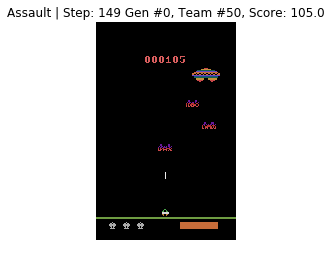

In [ ]:
%matplotlib inline
import time # for tracking time

tStart = time.time()

# first create an instance of the TpgTrainer
# this creates the whole population and everything
trainer = TpgTrainer(actions=range(7), teamPopSizeInit=50)

curScores = [] # hold scores in a generation
summaryScores = [] # record score summaries for each gen (min, max, avg)

# 5 generations isn't much (not even close), but some improvements
# should be seen.
for gen in range(5): # generation loop
    curScores = [] # new list per gen
    
    while True: # loop to go through agents
        teamNum = trainer.remainingAgents()
        agent = trainer.getNextAgent()
        if agent is None:
            break # no more agents, so proceed to next gen
        
        # check if agent already has score
        if agent.taskDone():
            score = agent.getOutcome()
        else:
            state = env.reset() # get initial state and prep environment
            score = 0
            for i in range(200): # run episodes that last 200 frames
                show_state(env, i, 'Assault', 'Gen #' + str(gen) + 
                           ', Team #' + str(teamNum) +
                           ', Score: ' + str(score)) # render env

                act = agent.act(getState(state)) # get action from agent

                # feedback from env
                state, reward, isDone, debug = env.step(act)
                score += reward # accumulate reward in score
                if isDone:
                    break # end early if losing state

            agent.reward(score) # must reward agent
            
        curScores.append(score) # store score
            
    # at end of generation, make summary of scores
    summaryScores.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores))) # min, max, avg
    trainer.evolve()
    
clear_output(wait=True)
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results:\nMin, Max, Avg')
for result in summaryScores:
    print(result[0],result[1],result[2])

## Example: Generational Selection with Multiprocessing (no graphics)

In [4]:
import multiprocessing as mp
import time

tStart = time.time()

lock = mp.Lock()

trainer = TpgTrainer(actions=range(7), teamPopSizeInit=50)

processes = 4 # how many to run concurrently (4 is best for my local desktop)

m = mp.Manager()
envQueue = m.Queue()
# each process needs its own environment
for i in range(processes):
    envQueue.put(gym.make('Assault-v0'))
    
summaryScores = [] # record score summaries for each gen (min, max, avg)

# run agent in function to work with multiprocessing
def runAgent(agenteqsq):
    agent = agenteqsq[0] # get agent
    eq = agenteqsq[1] # get environment queue
    sq = agenteqsq[2] # get score queue
    
    # check if agent already has score
    if agent.taskDone():
        sq.put(agent.getOutcome()) # store score
        return
        
    print('Waiting for env...')
    print(eq.qsize())
    env = eq.get() # get an environment
    print('Agent #' + str(agent.getAgentNum()) + ' starting.')
    state = env.reset() # get initial state and prep environment
    score = 0
    for i in range(200): # run episodes that last 200 frames
        act = agent.act(getState(state)) # get action from agent

        # feedback from env
        state, reward, isDone, debug = env.step(act)
        score += reward # accumulate reward in score
        if isDone:
            break # end early if losing state
    lock.acquire()
    agent.reward(score) # must reward agent
    lock.release()
    sq.put(score) # store score
    
    print('Agent #' + str(agent.getAgentNum()) + ' finished with score ' + str(score))
    
    eq.put(env) # put environment back
    
    
for gen in range(5): # generation loop
    curScores = m.Queue() # hold scores in a generation (queue so thread safe)
    
    # run generation
    pool = mp.Pool(processes=processes)
    # skipTasks=[] so we get all agents, even if already scored,
    # just to report the obtained score for all agents.
    pool.map(runAgent, 
                 [(agent, envQueue, curScores) 
                  for agent in trainer.getAllAgents(skipTasks=[])])
         
    scores = [] # convert scores into list
    while not curScores.empty():
        scores.append(curScores.get())

    # at end of generation, make summary of scores
    summaryScores.append((min(scores), 
                    max(scores),
                    sum(scores)/len(scores))) # min, max, avg
    trainer.evolve()
    
clear_output(wait=True)
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results: ' + str(summaryScores))

Waiting for env...
4
Agent #49 starting.
Agent #49 finished with score 0.0
Waiting for env...
4
Waiting for env...
3
Agent #48 starting.
Agent #45 starting.
Agent #48 finished with score 0.0
Agent #45 finished with score 0.0
Waiting for env...
3
Waiting for env...
3
Agent #47 starting.
Agent #44 starting.
Waiting for env...
2
Agent #41 starting.
Agent #44 finished with score 168.0
Agent #47 finished with score 0.0
Waiting for env...
2
Waiting for env...
2
Agent #46 starting.
Agent #43 starting.
Agent #41 finished with score 0.0
Waiting for env...
2
Agent #40 starting.
Waiting for env...
1
Agent #37 starting.
Agent #43 finished with score 0.0
Agent #46 finished with score 0.0
Waiting for env...
1
Agent #42 starting.
Agent #40 finished with score 0.0
Agent #37 finished with score 0.0
Waiting for env...
2
Waiting for env...
2
Agent #39 starting.
Agent #36 starting.
Agent #42 finished with score 84.0
Agent #39 finished with score 0.0
Agent #36 finished with score 147.0
Waiting for env...
2

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Agent #31 finished with score 0.0
Agent #26 finished with score 0.0
Waiting for env...
1
Waiting for env...
1
Agent #21 starting.
Agent #25 starting.
Agent #23 finished with score 0.0
Waiting for env...
1
Agent #22 starting.
Waiting for env...
0
Agent #21 finished with score 0.0
Agent #25 finished with score 0.0
Waiting for env...
0
Agent #18 starting.
Agent #20 starting.
Agent #22 finished with score 0.0
Waiting for env...
1
Agent #15 starting.
Agent #18 finished with score 147.0
Agent #20 finished with score 0.0
Waiting for env...
1
Waiting for env...
1
Waiting for env...
0
Agent #17 starting.
Agent #19 starting.
Agent #15 finished with score 0.0
Waiting for env...
0
Waiting for env...
0
Agent #12 starting.
Agent #19 finished with score 0.0
Agent #14 starting.
Agent #12 finished with score 147.0
Waiting for env...
0
Waiting for env...
0
Agent #9 starting.
Agent #14 finished with score 0.0
Waiting for env...
0
Agent #6 starting.
Agent #9 finished with score 0.0
Waiting for env...
0
Ag

Process PoolWorker-53:
Process PoolWorker-43:
Process PoolWorker-46:
Process PoolWorker-52:
Process PoolWorker-45:
Process PoolWorker-51:
Process PoolWorker-44:
Process PoolWorker-54:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-50:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ryan/anaconda3/envs/oaigym/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/ryan/anaconda3/envs/oaigym/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    self.run()
    self.run()
  File "/home/ryan/anaconda3/envs/oaigym/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/ryan/anaconda3/envs/oaigym/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
  File "/home/ryan/anaconda3/envs/oaigym/lib/python2.7/multiprocessing/process.py", line 11

## Tournament Selection